In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os, time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- <span style = 'font-size:1.2em;line-height:1.5em'>이번 실습 자료에서는 Optimizer를 다르게 설정했을 때, 어떤 패턴으로 수렴이 되는지 봅시다.</span>

## 1. 모델을 클래스 형식으로 선언합니다.

In [2]:
class MyNet(nn.Module):
    def __init__(self, dim_in, dim_h1, dim_h2, dim_out):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(dim_in,dim_h1)
        self.fc2 = nn.Linear(dim_h1,dim_h2)
        self.fc3 = nn.Linear(dim_h2,dim_out)
        
    def forward(self, x):
        h1 = self.fc1(x)
        h1 = F.relu(h1)
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        out = self.fc3(h2)
        # F.cross_entropy = F.log_softmax + F.nll_loss
        # 뒤에서 cross_entropy를 사용하려면, 여기서 softmax 빼야됩니다.
        # 이번엔 모델에서 softmax를 빼고, 뒤의 loss에서 cross_entropy loss를 활용해봅시다.
        return out

## 2. train() 함수

In [3]:
def train(model, data_loader, optimizer, criterion, device):
    model.train() # 모델을 학습모드로!
    trn_loss = 0
    for i, (x, y) in enumerate(data_loader):
        # Step 1. mini-batch에서 x,y 데이터를 얻고, 원하는 device에 위치시키기
        x = x.view(-1, 784).to(device) # x.shape: [batch_size,28,28] -> [batch_size, 784]
        y = y.to(device)
        
        # Step 2. gradient 초기화
        optimizer.zero_grad()
        
        # Step 3. Forward Propagation
        y_pred_prob = model(x)
        
        # Step 4. Loss Calculation
        loss = criterion(y_pred_prob, y)
        
        # Step 5. Gradient Calculation (Backpropagation)
        loss.backward()
        
        # Step 6. Update Parameter (by Gradient Descent)
        optimizer.step()
        
        # Step 7. trn_loss 변수에 mini-batch loss를 누적해서 합산
        trn_loss += loss.item()
        
    # Step 8. 데이터 한 개당 평균 train loss
    avg_trn_loss = trn_loss / len(data_loader.dataset)
    return avg_trn_loss

## 3. evaluate() 함수

In [4]:
def evaluate(model, data_loader, optimizer, criterion, device):
    model.eval() # 모델을 평가모드로!
    eval_loss = 0
    
    results_pred = []
    results_real = []
    with torch.no_grad(): # evaluate()함수에는 단순 forward propagation만 할 뿐, gradient 계산 필요 X.
        for i, (x, y) in enumerate(data_loader):
            # Step 1. mini-batch에서 x,y 데이터를 얻고, 원하는 device에 위치시키기
            x = x.view(-1,784).to(device) # x.shape: [batch_size,28,28] -> [batch_size, 784]
            y = y.to(device)

            # Step 2. Forward Propagation
            y_pred_prob = model(x)

            # Step 3. Loss Calculation
            loss = criterion(y_pred_prob, y)
            
            # Step 4. Predict label
            y_pred_label = torch.argmax(y_pred_prob, dim=1)
            
            # Step 5. Save real and predicte label
            results_pred.extend(y_pred_label.detach().cpu().numpy())
            results_real.extend(y.detach().cpu().numpy())
            
            # Step 6. eval_loss변수에 mini-batch loss를 누적해서 합산
            eval_loss += loss.item()

    # Step 7. 데이터 한 개당 평균 eval_loss와 accuracy구하기
    avg_eval_loss = eval_loss / len(data_loader.dataset)
    results_pred = np.array(results_pred)
    results_real = np.array(results_real)
    accuracy = np.sum(results_pred == results_real) / len(results_real)
    
    return avg_eval_loss, accuracy

## 4. 매 Epoch에 드는 시간 측정

In [5]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## 5. 학습하기

- <span style = 'font-size:1.2em;line-height:1.5em'>Dataset과 Mini-batch를 자동으로 생성할 DataLoader준비하기</span>

In [6]:
# torchvision에서도 MNIST데이터를 제공합니다. 
# 이 데이터를 다운 받을 디렉토리(data_path) 존재 여부를 확인하고 존재하지 않으면 생성 
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
# data 변환 방법 선언 (data transform method)
# 아래 예시: numpy형태의 데이터를 받으면 걔를 tensor로 변환해줘!
transform = transforms.Compose([transforms.ToTensor()])

# dataset을 생성 (torchvision에서 제공하는 데이터를 다운 받고, 위의 방법대로 변환)
trn_dset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
tst_dset = datasets.MNIST(root=data_path, train=False, transform=transform, download=True)

- <span style = 'font-size:1.2em;line-height:1.5em'>연산을 수행할 device를 설정하기</span>

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- <span style = 'font-size:1.2em;line-height:1.5em'>모델에 대한 객체 생성하기</span>

In [8]:
# stochastic gradient descent 방식
model_sgd = MyNet(dim_in=784, dim_h1=50, dim_h2=100, dim_out=10)
model_sgd = model_sgd.to(device)

# adagrad 방식
model_ada = MyNet(dim_in=784, dim_h1=50, dim_h2=100, dim_out=10)
model_ada = model_ada.to(device)

# RMSProp 방식
model_rms = MyNet(dim_in=784, dim_h1=50, dim_h2=100, dim_out=10)
model_rms = model_rms.to(device)

# adam 방식
model_adam = MyNet(dim_in=784, dim_h1=50, dim_h2=100, dim_out=10)
model_adam = model_adam.to(device)

- <span style = 'font-size:1.2em;line-height:1.5em'>loss function 정의하기</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>예전 실습 파일에는 손실 함수인 F.nll_loss()가 train(), evaluate() 함수 안에서 바로 사용되었음</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>이번 손실 함수는 train(), evaluate() 함수 밖에서 정의하고 안에서는 정의한 함수를 사용하는 방식으로</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'>어떻게 사용해도 상관없으니, 편한대로 사용하세요.</span>

In [9]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

- <span style = 'font-size:1.2em;line-height:1.5em'>학습한 모델을 저장할 directory 생성하기</span>

In [10]:
save_dir = 'models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

- <span style = 'font-size:1.2em;line-height:1.5em'>필요한 hyperparameter값 설정하기</span>

In [11]:
N_EPOCHS = 10
LR = 2e-4
BATCH_SIZE = 2**9

- <span style = 'font-size:1.2em;line-height:1.5em'>Mini-batch를 자동으로 생성할 DataLoader준비하기</span>

In [12]:
trn_loader = DataLoader(trn_dset, batch_size = BATCH_SIZE, shuffle=True, drop_last=False)
tst_loader = DataLoader(tst_dset, batch_size = BATCH_SIZE, shuffle=False, drop_last=False)

- <span style = 'font-size:1.2em;line-height:1.5em'>optimizer 생성하기</span>

In [13]:
opt_sgd = optim.SGD(model_sgd.parameters(), lr = LR)
opt_ada = optim.Adagrad(model_ada.parameters(), lr = LR)
opt_rms = optim.RMSprop(model_rms.parameters(), lr = LR)
opt_adam = optim.Adam(model_adam.parameters(), lr = LR)

- <span style = 'font-size:1.2em;line-height:1.5em'>trn_data에 대해서 train()함수를, tst_data에 대해서 evaluate()함수를 반복적으로 호출하면서 모델을 학습</span>
    - <span style = 'font-size:1.2em;line-height:1.5em'>매 epoch마다 학습이 마무리되면, 모델 평가를 진행한다</span>

In [14]:
param_dict = {
    'SGD': {'model': model_sgd, 'optimizer': opt_sgd},
    'Adagrad': {'model': model_ada, 'optimizer': opt_ada},
    'RMSProp': {'model': model_rms, 'optimizer': opt_rms},
    'Adam': {'model': model_adam, 'optimizer': opt_adam},
}

In [15]:
best_val_loss = float('inf')
keys = ['SGD', 'Adagrad', 'RMSProp', 'Adam']
result_dict = {
    'SGD': {'trn_loss': [], 'val_loss': [], 'val_acc': []},
    'Adagrad': {'trn_loss': [], 'val_loss': [], 'val_acc': []},
    'RMSProp': {'trn_loss': [], 'val_loss': [], 'val_acc': []},
    'Adam': {'trn_loss': [], 'val_loss': [], 'val_acc': []},
}

for key in keys:
    print(f'optimizer: {key}')
    start_time = time.time()
    for epoch in range(N_EPOCHS):
        trn_loss = train(model=param_dict[key]['model'], 
                         data_loader=trn_loader, 
                         optimizer=param_dict[key]['optimizer'], 
                         criterion=loss_func,
                         device=device)

        val_loss, accuracy = evaluate(model=param_dict[key]['model'], 
                                      data_loader=tst_loader, 
                                      optimizer=param_dict[key]['optimizer'], 
                                      criterion=loss_func,
                                      device=device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    #     if val_loss < best_val_loss:
    #         best_val_loss = val_loss
    #         torch.save(model.state_dict(), f'{save_dir}/my_model.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {trn_loss:.3f} | Test Loss: {val_loss:.3f} | Test Acc: {100*accuracy:.3f}% ')

        result_dict[key]['trn_loss'] = trn_loss
        result_dict[key]['val_loss'] = val_loss
        result_dict[key]['val_acc'] = accuracy

optimizer: SGD
Epoch: 01 | Time: 0m 12s
	Train Loss: 1.569 | Test Loss: 0.581 | Test Acc: 85.130% 
Epoch: 02 | Time: 0m 25s
	Train Loss: 0.468 | Test Loss: 0.380 | Test Acc: 88.650% 
Epoch: 03 | Time: 0m 37s
	Train Loss: 0.365 | Test Loss: 0.325 | Test Acc: 90.390% 
Epoch: 04 | Time: 0m 50s
	Train Loss: 0.325 | Test Loss: 0.292 | Test Acc: 91.460% 
Epoch: 05 | Time: 1m 2s
	Train Loss: 0.296 | Test Loss: 0.274 | Test Acc: 91.900% 
Epoch: 06 | Time: 1m 15s
	Train Loss: 0.274 | Test Loss: 0.254 | Test Acc: 92.710% 
Epoch: 07 | Time: 1m 28s
	Train Loss: 0.257 | Test Loss: 0.240 | Test Acc: 93.010% 
Epoch: 08 | Time: 1m 40s
	Train Loss: 0.240 | Test Loss: 0.227 | Test Acc: 93.340% 
Epoch: 09 | Time: 1m 53s
	Train Loss: 0.224 | Test Loss: 0.217 | Test Acc: 93.620% 
Epoch: 10 | Time: 2m 6s
	Train Loss: 0.212 | Test Loss: 0.203 | Test Acc: 93.950% 
optimizer: Adagrad
Epoch: 01 | Time: 0m 12s
	Train Loss: 2.250 | Test Loss: 2.208 | Test Acc: 43.300% 
Epoch: 02 | Time: 0m 25s
	Train Loss: 2.176 

In [ ]:
plt.plot(result_dict['SGD']['trn_loss'])
plt.plot(result_dict['AdaGrad']['trn_loss'], c='k')
plt.plot(result_dict['RMSProp']['trn_loss'], c='b')
plt.plot(result_dict['Adam']['trn_loss'], c='r')
plt.legend(['SGD', 'AdaGrad', 'RMSProp', 'Adam'])

## train_dataset, test_dataset을 생성합니다.

In [3]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
transform = transforms.Compose([transforms.ToTensor()]) # 이미지를 텐서로 변경하고

trn_dset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
tst_dset = datasets.MNIST(root=data_path, train=False, transform=transform, download=False)

## 위에서 생성된 dataset으로 dataloader를 만듭니다.

In [4]:
batch_size = 2**9
trn_loader = DataLoader(trn_dset, batch_size = batch_size, shuffle=True, drop_last=False)
tst_loader = DataLoader(tst_dset, batch_size = batch_size, shuffle=False, drop_last=False)

## 모델을 생성하고 이 모델을 gpu에서 사용할지 cpu에서 사용할지 결정합니다.

In [5]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

model = MyNet()
model = model.to(device)

cpu


## optimizer를 설정합니다.

In [6]:
my_opt = optim.Adam(params = model.parameters(), lr = 2e-4)

## 학습해 볼까요?

In [7]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for batch_idx, (x_batch, y_batch) in enumerate(trn_loader):
        x_batch = x_batch.reshape(-1,784).to(device)
        y_batch = y_batch.to(device)
        my_opt.zero_grad()
        y_batch_prob = model(x_batch)
        loss = F.nll_loss(y_batch_prob, y_batch)
        loss.backward()
        my_opt.step()
        if (batch_idx+1)%100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                                                                           batch_idx * len(x_batch), 
                                                                           len(trn_loader.dataset),
                                                                           100 * batch_idx / len(trn_loader),
                                                                           loss.item()))
    # 매 epoch이 끝날때 결과 찍기
    print('Train Epoch: {} [{}/{} (100%)]\tLoss: {:.6f}'.format(epoch, 
                                                                   len(trn_loader.dataset), 
                                                                   len(trn_loader.dataset),
                                                                loss.item()))
    model.eval()
    y_pred_list = []
    y_real_list = []
    tst_loss = 0
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch) in enumerate(tst_loader):
            x_batch = x_batch.reshape(-1,784).to(device)
            y_batch = y_batch.to(device)
            y_batch_prob = model(x_batch)
            y_batch_pred = np.argmax(y_batch_prob, axis=1)
#             print(y_batch_pred)
#             print(y_batch)
#             y_batch_pred = y_batch_prob.argmax(dim=1, keepdim=True)
            loss = F.nll_loss(y_batch_prob, y_batch, reduction='sum')
            tst_loss += loss
            
            y_pred_list.append(y_batch_pred.detach().numpy())
            y_real_list.append(y_batch.detach().numpy())
            
        y_real = np.concatenate([x for x in y_real_list], axis=0)
        y_pred = np.concatenate([x for x in y_pred_list], axis=0)
        tst_loss /= y_real.shape[0]
        correct  = np.sum(y_real == y_pred)
        accuracy = 100*correct / len(tst_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(tst_loss, 
                                                                                     correct, 
                                                                                     len(tst_loader.dataset),
                                                                                     accuracy))

Train Epoch: 0 [25344/60000 (42%)]	Loss: 0.555192
Train Epoch: 0 [50944/60000 (85%)]	Loss: 0.348267
Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.276718

Test set: Average loss: 0.3348, Accuracy: 9078/10000 (91%)

Train Epoch: 1 [25344/60000 (42%)]	Loss: 0.331737
Train Epoch: 1 [50944/60000 (85%)]	Loss: 0.331150
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.238821

Test set: Average loss: 0.2526, Accuracy: 9282/10000 (93%)

Train Epoch: 2 [25344/60000 (42%)]	Loss: 0.230109
Train Epoch: 2 [50944/60000 (85%)]	Loss: 0.177349
Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.178517

Test set: Average loss: 0.2084, Accuracy: 9391/10000 (94%)

Train Epoch: 3 [25344/60000 (42%)]	Loss: 0.203229
Train Epoch: 3 [50944/60000 (85%)]	Loss: 0.189899
Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.151668

Test set: Average loss: 0.1819, Accuracy: 9459/10000 (95%)

Train Epoch: 4 [25344/60000 (42%)]	Loss: 0.149744
Train Epoch: 4 [50944/60000 (85%)]	Loss: 0.152287
Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.255993



# 여러 optimizer에 대해 비교해볼까요?

In [6]:
batch_size = 2**8
trn_loader = DataLoader(trn_dset, batch_size = batch_size, shuffle=True, drop_last=False)
tst_loader = DataLoader(tst_dset, batch_size = batch_size, shuffle=False, drop_last=False)

In [7]:
opt_list = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']
model_dict    = dict()
trn_loss_dict = dict()
tst_loss_dict = dict()
opt_dict      = dict()
accuracy_dict = dict()

for opt in opt_list:
    model_dict[opt]    = MyNet().to(device)
    trn_loss_dict[opt] = list()
    tst_loss_dict[opt] = list()
    accuracy_dict[opt] = list()

opt_dict['SGD'] = optim.SGD(model_dict['SGD'].parameters(), lr=2e-4)
opt_dict['AdaGrad'] = optim.Adagrad(model_dict['AdaGrad'].parameters(), lr=2e-4)
opt_dict['RMSProp'] = optim.RMSprop(model_dict['RMSProp'].parameters(), lr=2e-4)
opt_dict['Adam'] = optim.Adam(model_dict['Adam'].parameters(), lr=2e-4)

In [8]:
n_epochs = 10

for opt_name, optimizer in opt_dict.items():
    for epoch in range(n_epochs):
        model_dict[opt_name].train()
        total_trn_loss = 0
        for batch_idx, (x_batch, y_batch) in enumerate(trn_loader):
            x_batch = x_batch.reshape(-1,784).to(device)
            y_batch = y_batch.to(device)
            opt_dict[opt_name].zero_grad()
            y_batch_prob = model_dict[opt_name](x_batch)
            trn_loss = F.nll_loss(y_batch_prob, y_batch)
            trn_loss.backward()
            total_trn_loss += trn_loss.item() * y_batch.shape[0]
            opt_dict[opt_name].step()
        trn_loss_dict[opt_name].append(total_trn_loss/len(trn_loader.dataset))
        
        
        
        model_dict[opt_name].eval()
        total_tst_loss=0
        correct = 0
        with torch.no_grad():
            for batch_idx, (x_batch, y_batch) in enumerate(tst_loader):
                x_batch = x_batch.reshape(-1,784).to(device)
                y_batch = y_batch.to(device)
                y_batch_prob = model_dict[opt_name](x_batch)
                y_batch_pred = torch.argmax(y_batch_prob, axis=1)
                tst_loss = F.nll_loss(y_batch_prob, y_batch)
                total_tst_loss += tst_loss.item() * y_batch.shape[0]
                correct += np.sum(y_batch.detach().numpy() == y_batch_pred.detach().numpy())
        tst_loss_dict[opt_name].append(total_tst_loss / len(tst_loader.dataset))
        accuracy_dict[opt_name].append(correct / len(tst_loader.dataset))
        
        # 매 epoch이 끝날때 결과 찍기
        print('Optimizer: {}, Epoch: {} \t Trn Loss: {:.6f}'.format(opt_name, epoch, 
                                                                    total_trn_loss/len(trn_loader.dataset)))
        
        print('Optimizer: {}, Epoch: {} \t Tst Loss: {:.6f}, Accuracy: {:.2f}%'.format(opt_name, epoch, 
                                                                                       total_tst_loss/len(tst_loader.dataset), 
                                                                                       100*correct/len(tst_loader.dataset)))
    

Optimizer: SGD, Epoch: 0 	 Trn Loss: 2.301416
Optimizer: SGD, Epoch: 0 	 Tst Loss: 2.296272, Accuracy: 10.19%
Optimizer: SGD, Epoch: 1 	 Trn Loss: 2.291434
Optimizer: SGD, Epoch: 1 	 Tst Loss: 2.286153, Accuracy: 11.41%
Optimizer: SGD, Epoch: 2 	 Trn Loss: 2.281522
Optimizer: SGD, Epoch: 2 	 Tst Loss: 2.276024, Accuracy: 12.91%
Optimizer: SGD, Epoch: 3 	 Trn Loss: 2.271519
Optimizer: SGD, Epoch: 3 	 Tst Loss: 2.265704, Accuracy: 15.18%
Optimizer: SGD, Epoch: 4 	 Trn Loss: 2.261251
Optimizer: SGD, Epoch: 4 	 Tst Loss: 2.255026, Accuracy: 18.40%
Optimizer: SGD, Epoch: 5 	 Trn Loss: 2.250580
Optimizer: SGD, Epoch: 5 	 Tst Loss: 2.243857, Accuracy: 23.26%
Optimizer: SGD, Epoch: 6 	 Trn Loss: 2.239374
Optimizer: SGD, Epoch: 6 	 Tst Loss: 2.232087, Accuracy: 29.30%
Optimizer: SGD, Epoch: 7 	 Trn Loss: 2.227515
Optimizer: SGD, Epoch: 7 	 Tst Loss: 2.219596, Accuracy: 34.76%
Optimizer: SGD, Epoch: 8 	 Trn Loss: 2.214903
Optimizer: SGD, Epoch: 8 	 Tst Loss: 2.206294, Accuracy: 39.96%
Optimizer:

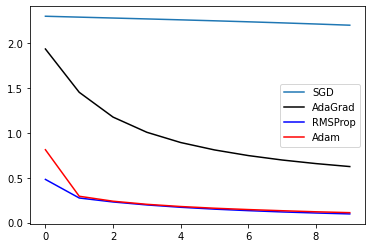

In [9]:
plt.plot(trn_loss_dict['SGD'])
plt.plot(trn_loss_dict['AdaGrad'], c='k')
plt.plot(trn_loss_dict['RMSProp'], c='b')
plt.plot(trn_loss_dict['Adam'], c='r')
plt.legend(['SGD', 'AdaGrad', 'RMSProp', 'Adam'])

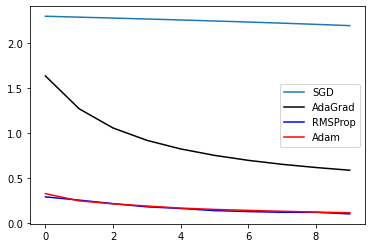

In [10]:
plt.plot(tst_loss_dict['SGD'])
plt.plot(tst_loss_dict['AdaGrad'], c='k')
plt.plot(tst_loss_dict['RMSProp'], c='b')
plt.plot(tst_loss_dict['Adam'], c='r')
plt.legend(['SGD', 'AdaGrad', 'RMSProp', 'Adam'])

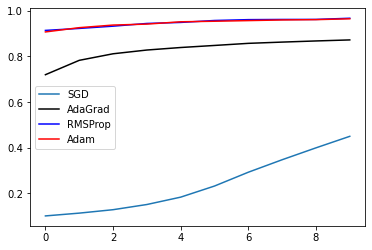

In [11]:
plt.plot(accuracy_dict['SGD'])
plt.plot(accuracy_dict['AdaGrad'], c='k')
plt.plot(accuracy_dict['RMSProp'], c='b')
plt.plot(accuracy_dict['Adam'], c='r')
plt.legend(['SGD', 'AdaGrad', 'RMSProp', 'Adam'])